In [392]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import os.path
import time
import tqdm

from tqdm import notebook
from bitmex import bitmex
from datetime import timedelta, datetime
from dateutil import parser
from stockstats import StockDataFrame as sdf
from pylab import rcParams

In [393]:
%matplotlib inline
%config InlineBackend.figure_format="retina"

pd.options.display.max_rows = 999
plt.rcParams["figure.figsize"]=(20, 15)
sns.set_style('whitegrid')
sns.set_context("notebook", font_scale=1.3)

In [394]:
api_key = 'YOUR_API_KEY' #get bitmex api key and paste here
api_secret = 'YOUR_API_SECRET' #get bitmex api secret and paste here
client = bitmex(test=False, api_key=api_key, api_secret=api_secret)

binsizes = {"1m": 1, "5m": 5, "1h": 60, "1d": 1440}
batch_size = 750

In [395]:
def min_data(symbol, kline_size, data):
    if len(data) > 0:  old = parser.parse(data["timestamp"].iloc[-1])
    else: old = client.Trade.Trade_getBucketed\
        (symbol=symbol, binSize=kline_size, count=1, reverse=False).result()[0][0]['timestamp']
    new = client.Trade.Trade_getBucketed\
    (symbol=symbol, binSize=kline_size, count=1, reverse=True).result()[0][0]['timestamp']
    
    return old, new

In [396]:
def get_all(symbol, kline_size, save = False):
    filename = '%s-%s-data.csv' % (symbol, kline_size)
    if os.path.isfile(filename): data_df = pd.read_csv(filename)
    else: data_df = pd.DataFrame()
    oldest_point, newest_point = min_data(symbol, kline_size, data_df)
    delta_min = (newest_point - oldest_point).total_seconds()/60
    available_data = math.ceil(delta_min/binsizes[kline_size])
    rounds = math.ceil(available_data / batch_size)
    if rounds > 0:
        for round_num in tqdm.notebook.tqdm(range(rounds)):
            time.sleep(1)
            new_time = (oldest_point + timedelta(minutes = round_num * batch_size * binsizes[kline_size]))
            data = client.Trade.Trade_getBucketed\
            (symbol=symbol, binSize=kline_size, count=batch_size, startTime = new_time).result()[0]
            temp_df = pd.DataFrame(data)
            data_df = data_df.append(temp_df)
    data_df.set_index('timestamp', inplace=True)
    if save and rounds > 0: data_df.to_csv(filename)

    return data_df

In [397]:
data = get_all("XBTUSD", "1h", save=True)

In [398]:
data = data[['close', 'trades']]

In [399]:
data = data['2018-01-01 00:00:00':]

In [400]:
data.index = data.index.tz_convert(None)

In [401]:
stock = sdf.retype(data)

In [402]:
stock['macds']

NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values


timestamp
2018-01-01 00:00:00     0.000000
2018-01-01 01:00:00    -2.524038
2018-01-01 02:00:00    -8.558121
2018-01-01 03:00:00   -11.774655
2018-01-01 04:00:00   -13.061879
                         ...    
2020-04-14 12:00:00    11.301303
2020-04-14 13:00:00    11.094044
2020-04-14 14:00:00    11.728024
2020-04-14 15:00:00    12.749540
2020-04-14 16:00:00    14.186618
Name: macds, Length: 20033, dtype: float64

In [403]:
def make_signal(stock):
               
    stock['result_earn'] = np.nan
    stock['status'] = ''
    stock['result'] = ''
    start_price_buy = np.nan
    start_price_sell = np.nan
    
    # buy when macdh>0, sell when macdh<0
    for i in stock.index[1:-1]:
        if (stock.loc[i, 'macdh'] < 0) and (stock.loc[i-timedelta(hours=1), 'result'] != 'sell'):
            stock.loc[i, 'result'] = 'sell'
            stock.loc[i, 'status'] = 'sell start'
            stock.loc[i-timedelta(hours=1), 'status'] = 'buy end'
            start_price_sell = stock.loc[i, 'close']
            stock.loc[i-timedelta(hours=1), 'result_earn'] =\
            stock.loc[i-timedelta(hours=1), 'close'] - start_price_buy
        elif (stock.loc[i, 'macdh'] < 0) and (stock.loc[i-timedelta(hours=1), 'result'] =='sell'):
            stock.loc[i, 'result'] = 'sell'
        elif (stock.loc[i, 'macdh'] > 0) and (stock.loc[i-timedelta(hours=1),'result'] !='buy'):
            stock.loc[i, 'result'] = 'buy'
            stock.loc[i, 'status'] = 'buy start'
            stock.loc[i-timedelta(hours=1), 'status'] = 'sell end'
            start_price_buy = stock.loc[i, 'close']
            stock.loc[i-timedelta(hours=1), 'result_earn'] =\
            start_price_sell - stock.loc[i-timedelta(hours=1), 'close']
        elif (stock.loc[i, 'macdh'] > 0) and (stock.loc[i-timedelta(hours=1), 'result'] == 'buy'):
            stock.loc[i, 'result'] = 'buy'   
            
    return stock

In [404]:
signal_stock = make_signal(stock)

In [405]:
def make_deal_list(data):
    
    data = data[data['status']!='']
    data = data.iloc[[x for x in range(1, len(data[:-1]))\
                                  if data.iloc[x-1, 7] != data.iloc[x+1, 7]]]
    if (data['status'][0]=='buy end') or (data['status'][0]=='sell end'):
        data = data[1:]
    if (data['status'][-1]=='buy start') or (data['status'][-1]=='sell start'):
        data = data[:-1]
    
    deal_list = [] 
    for i in range(len(data)):
        if i%2!=0:
            deal_list.append({
                'date_start': data.iloc[i-1].name,
                'date_finish': data.iloc[i].name,
                'price_start': data.iloc[i-1, 0],
                'price_finish': data.iloc[i, 0]
            })
    
    return pd.DataFrame(deal_list)

In [406]:
deal = make_deal_list(signal_stock)

In [407]:
deal

,date_start,date_finish,price_start,price_finish
0,2018-01-01 01:00:00,2018-01-01 04:00:00,13670.5,13477.5
1,2018-01-01 05:00:00,2018-01-01 11:00:00,13665.5,13579.5
2,2018-01-01 12:00:00,2018-01-01 20:00:00,13240.5,13352.0
3,2018-01-01 21:00:00,2018-01-02 04:00:00,13487.5,13374.0
4,2018-01-02 05:00:00,2018-01-02 09:00:00,13106.5,13459.0
...,...,...,...,...
1338,2020-04-11 18:00:00,2020-04-11 21:00:00,6791.5,6791.5
1339,2020-04-11 22:00:00,2020-04-12 23:00:00,6865.0,7031.5
1340,2020-04-13 00:00:00,2020-04-13 15:00:00,6905.5,6728.5
1341,2020-04-13 16:00:00,2020-04-14 10:00:00,6777.0,6858.0


In [408]:
def drow_grafics(df, test_period):
    fig, axs = plt.subplots(2)
 
    # get size of the first plot
    max_point = max(df['close'][test_period[0]:test_period[1]])
    min_point = min(df['close'][test_period[0]:test_period[1]])
    padding_length = (max_point-min_point)*0.1
    
    # clear data
    point_data = stock[stock['status']!=''][test_period[0]:test_period[1]]
    point_data = point_data.iloc[[x for x in range(1, len(point_data[:-1]))\
                                  if point_data.iloc[x-1, 7] != point_data.iloc[x+1, 7]]]
    if (point_data['status'][0]=='buy end') or (point_data['status'][0]=='sell end'):
        point_data = point_data[1:]
    if (point_data['status'][-1]=='buy start') or (point_data['status'][-1]=='sell start'):
        point_data = point_data[:-1]
        
    # collect all the points
    buy_x_point_for_lines = point_data[test_period[0]:test_period[1]].\
    loc[(point_data['status'] == 'buy start')|(point_data['status'] == 'buy end')].index
    buy_y_point_for_lines = point_data[test_period[0]:test_period[1]].\
    loc[(point_data['status'] == 'buy start')|(point_data['status'] == 'buy end')]['close']
    sell_x_point_for_lines = point_data[test_period[0]:test_period[1]].\
    loc[(point_data['status'] == 'sell start')|(point_data['status'] == 'sell end')].index
    sell_y_point_for_lines = point_data[test_period[0]:test_period[1]].\
    loc[(point_data['status'] == 'sell start')|(point_data['status'] == 'sell end')]['close']
    
    # plot buy and sell lines from points
    for i in range(0, len(buy_x_point_for_lines), 2):
        axs[0].plot(buy_x_point_for_lines[i:i+2], buy_y_point_for_lines[i:i+2], 'go-', linewidth=5)        
    for i in range(0, len(sell_x_point_for_lines), 2):
        axs[0].plot(sell_x_point_for_lines[i:i+2], sell_y_point_for_lines[i:i+2], 'ro-', linewidth=5)
        
    # write earned for each line and total
    for i in point_data[~np.isnan(point_data['result_earn'])]\
                              [test_period[0]:test_period[1]].index:
        result_earn_for_print = point_data.loc[i, 'result_earn']
        if result_earn_for_print>=0:
            axs[0].text(i, point_data.loc[i, 'close'] + padding_length, f"+{result_earn_for_print:.0f}")
        else: 
            axs[0].text(i, point_data.loc[i, 'close'] + padding_length, f"{result_earn_for_print:.0f}")
    total_earn_test = sum(point_data[~np.isnan(point_data['result_earn'])]\
                          [test_period[0]:test_period[1]]['result_earn'])
    total_earn_all = sum(df[~np.isnan(df['result_earn'])]['result_earn'])
    axs[0].text(test_period[0], max_point, f" Total earned in the test period: \
    {total_earn_test:.2f}\n Total earned since 2018: {total_earn_all:.2f}")
    
    # plot BTC
    axs[0].plot(df.index, df['close'], linewidth=2, color='steelblue', label = 'BTC')
    axs[0].set_xlim(test_period[0],test_period[1])
    axs[0].set_ylim(min_point-padding_length, max_point+padding_length)  
    axs[0].set_title(f" Buy and sell from  {test_period[0]}  to  {test_period[1]}")
    axs[0].legend()
    
    # get size of the second plot
    max_point_m = max(df['macd'][test_period[0]:test_period[1]])
    min_point_m = min(df['macd'][test_period[0]:test_period[1]])
    padding_length_m = (max_point_m-min_point_m)*0.1    
    
    # plot macd
    axs[1].plot(df.index, df['macd'], color = 'Blue', label = 'MACD', linewidth=1)
    axs[1].plot(df.index, df['macds'], color ='red', label='Signal', linewidth=1)
    axs[1].plot(df.index, df['macdh'], color ='grey', label='Hist', linewidth=1)
    axs[1].fill_between(df.index, df['macdh'], 0, alpha=0.5, facecolor='grey', edgecolor='grey')
    axs[1].axhline(0, color='black', linewidth=1, linestyle='-' )
    axs[1].set_xlim(test_period[0],test_period[1])
    axs[1].set_ylim(min_point_m-padding_length_m, max_point_m+padding_length_m)
    axs[1].legend()
    
    plt.subplots_adjust(wspace=0, hspace=0.07)

In [409]:
test_period = ['2018-01-01 00:00:00','2018-01-07 00:00:00']

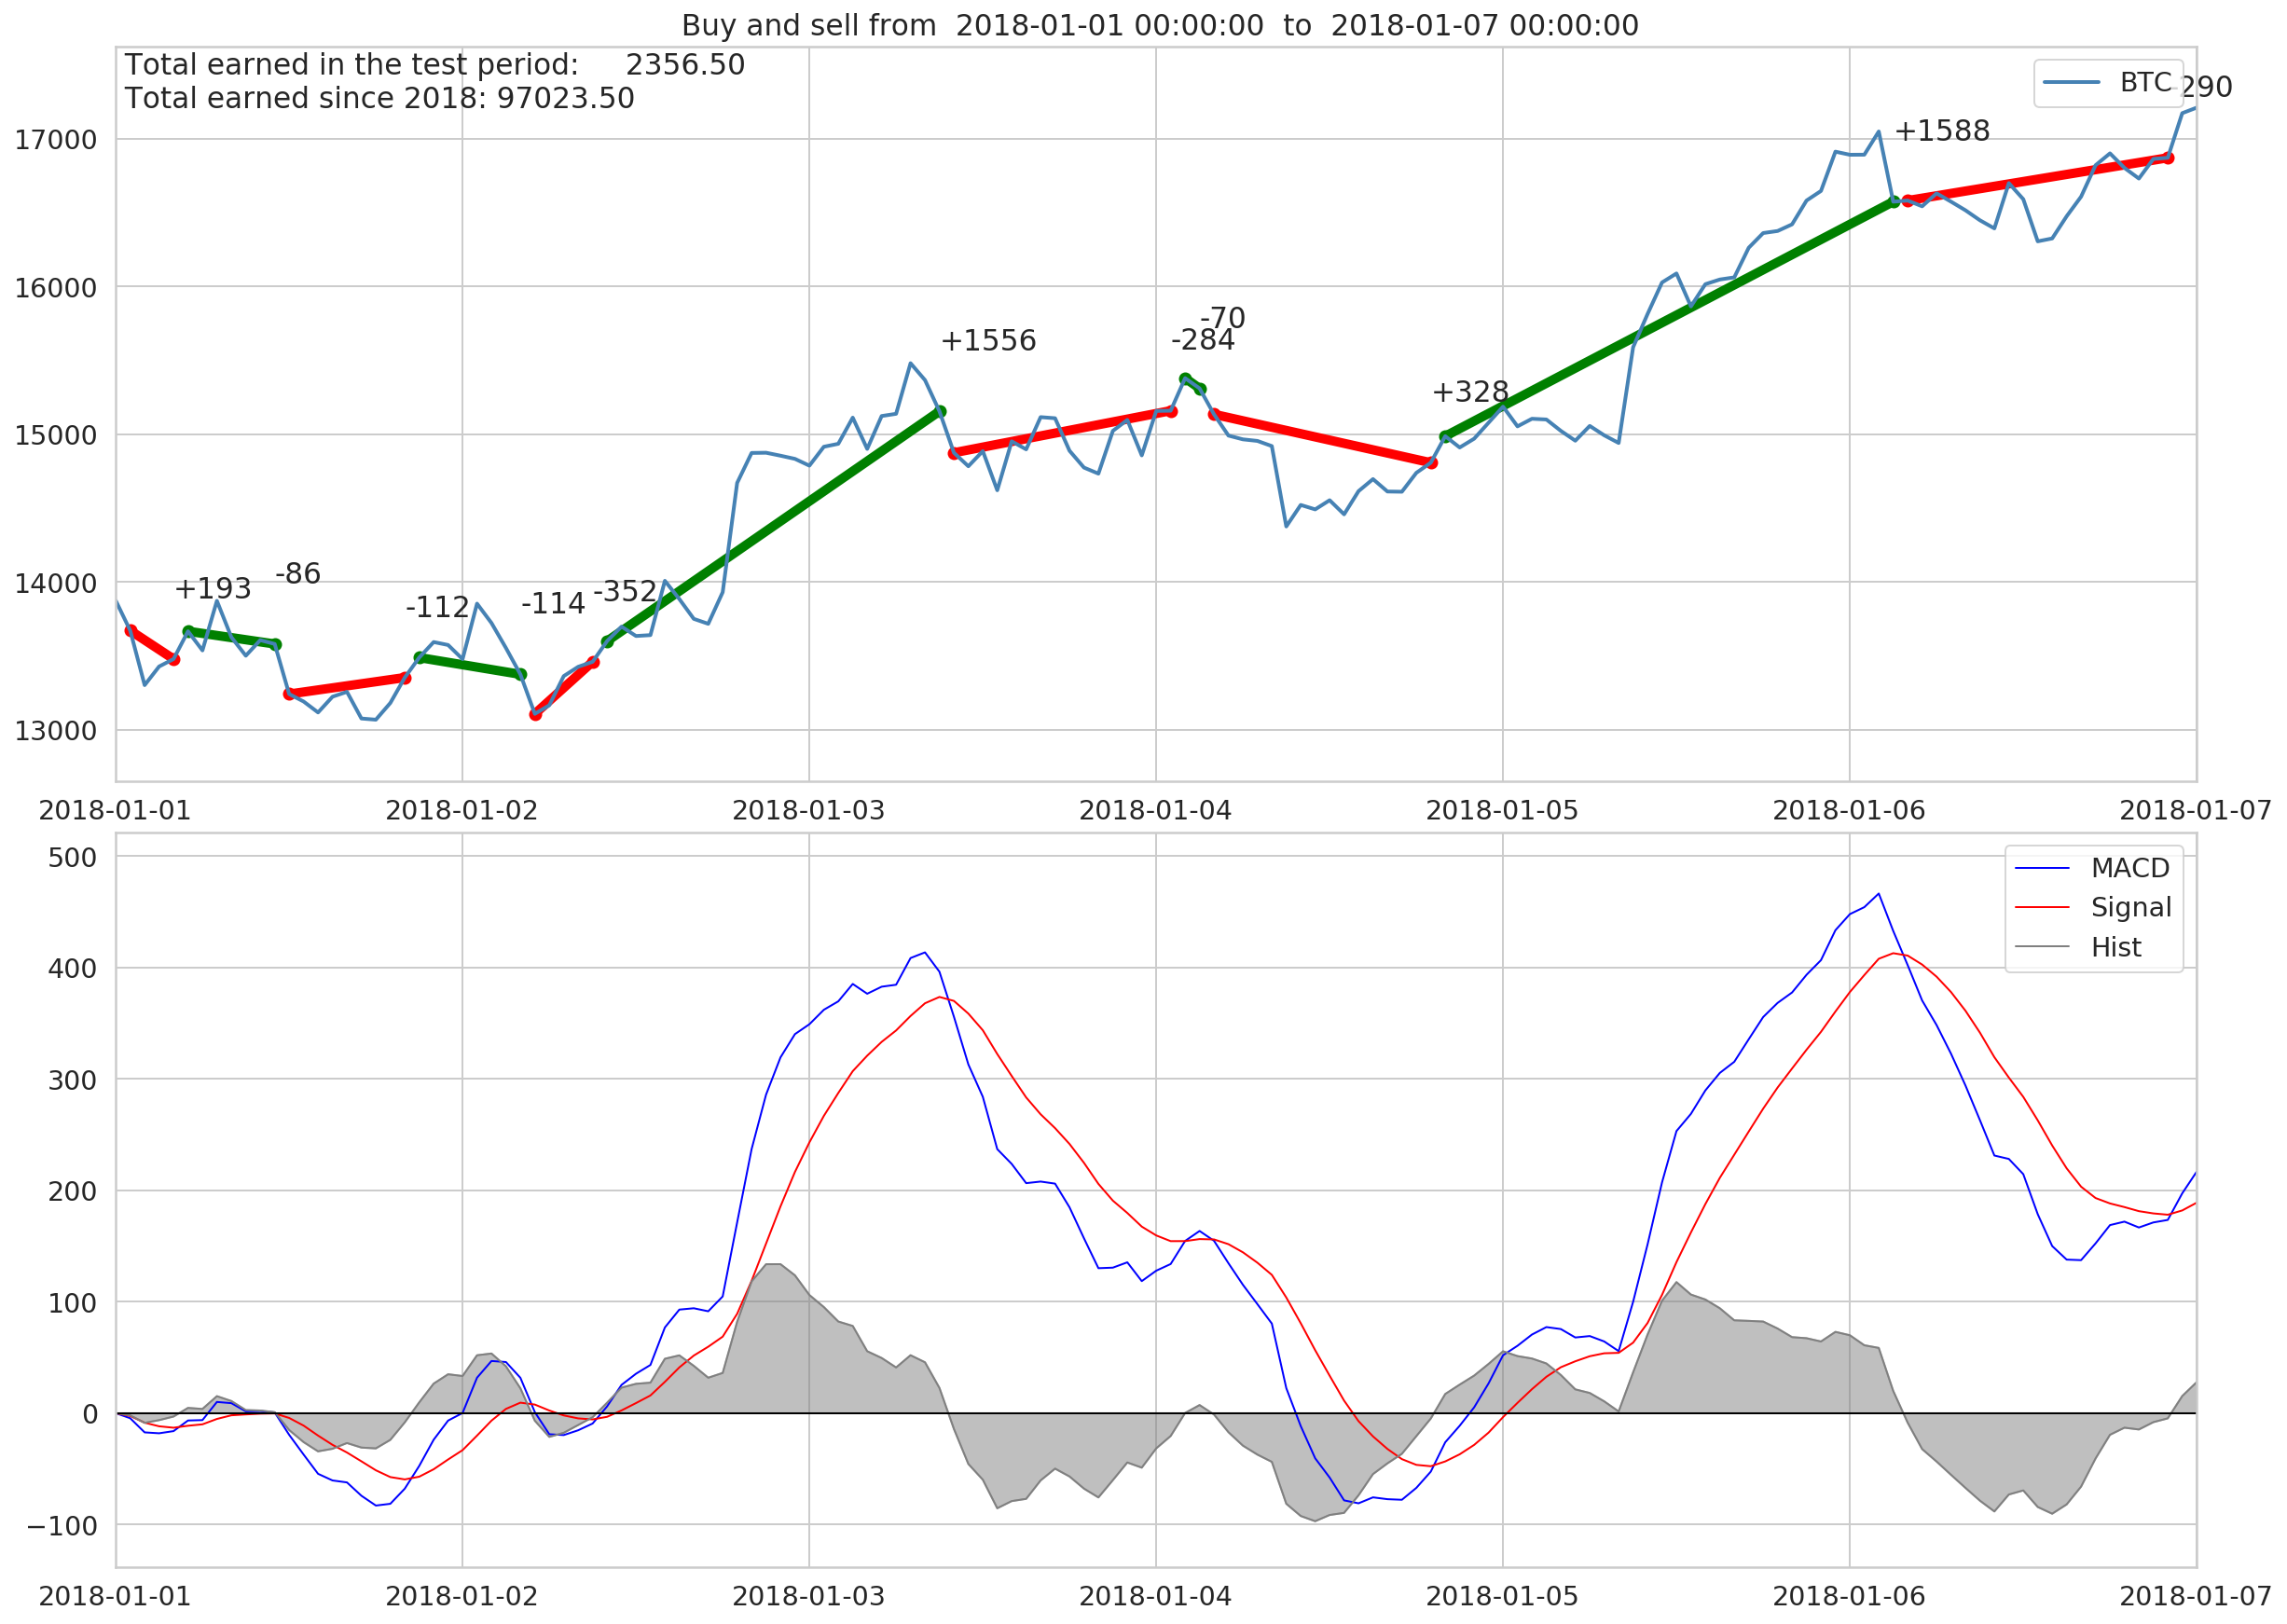

In [410]:
drow_grafics(stock, test_period)

In [412]:
# Ввиду того, что macdh = macd - signal, условие о пересечении macd и signal можно опустить как избыточное. 
# Тогда, положитьельные бары macdh сигнализируют о входе в покупку, отрицательные - в продажу.

# Возможно, "бары" имелись ввиду как бары гистограммы линии MACD (ее иногда изображают гистограммой),
# но стратегия, основанная на таком предположении, давала гараздо худшие результаты.